Import Libraries

In [12]:
# Import necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt

Load and Preprocess the Data

In [2]:
# Load the dataset
file_path = 'GOOGL_2006-01-01_to_2018-01-01.csv'
df1 = pd.read_csv(file_path, parse_dates=['Date'])  # Parse 'Date' as datetime
df1.set_index('Date', inplace=True)  # Set 'Date' as the index
df1 = df1.drop('Name', axis=1)  # Drop unnecessary 'Name' column

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(df1.values)



Prepare Sequences for RNN

In [3]:
# Define sequence length
sequence_length = 100

# Prepare input (X) and output (Y) sequences
X, Y = [], []
for i in range(len(data_normalized) - sequence_length):
    X.append(data_normalized[i:i + sequence_length])  # Input: sequence_length x num_features
    Y.append(data_normalized[i + sequence_length])    # Output: num_features

X = np.array(X)  # Shape: (samples, sequence_length, num_features)
Y = np.array(Y)  # Shape: (samples, num_features)

Split Data into Training and Testing Sets

In [4]:
# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(X))
X_train, X_test = X[:split_index], X[split_index:]
Y_train, Y_test = Y[:split_index], Y[split_index:]



Build and Compile the LSTM Model

In [5]:
# Build the LSTM model for multivariate input/output
model = Sequential([
    LSTM(units=80, input_shape=(sequence_length, X.shape[2])),  # Sequence length and features
    Dense(units=Y.shape[1])  # Number of output features
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')




2024-12-01 13:38:44.888038: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/irene/.local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Train the LSTM Model

In [6]:
# Train the model
model.fit(X_train, Y_train, epochs=20, batch_size=20, verbose=1)

Epoch 1/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.0109
Epoch 2/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 5.2284e-04
Epoch 3/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 4.8295e-04
Epoch 4/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 5.1577e-04
Epoch 5/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 4.3699e-04
Epoch 6/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 3.9232e-04
Epoch 7/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 5.0120e-04
Epoch 8/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 3.9231e-04
Epoch 9/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 3.9018e-04
Epoch 10/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 4.3380e-04
Epoch 11/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 3.7662e-04
Epoch 12/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 3.7415e-04
Epoch 13/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 4.1582e-04
Epoch 14/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 3.

Predict on the Test Set

In [ ]:
# Predict on the test set
predictions = model.predict(X_test)

# Inverse scale predictions and actual values for evaluation
predictions_rescaled = scaler.inverse_transform(predictions)
Y_test_rescaled = scaler.inverse_transform(Y_test)

# Evaluate the model using Mean Squared Error (MSE)
mse = root_mean_squared_error(Y_test_rescaled, predictions_rescaled)
print(f"Mean Squared Error: {mse}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Mean Squared Error: 248005744222.337


 Visualize Actual vs Predicted

Root Mean Squared Error: 11.47975313634463
Root Mean Squared Error: 11.677447909534099
Root Mean Squared Error: 11.920643943850834
Root Mean Squared Error: 12.651677722105648
Root Mean Squared Error: 986732.6379067636


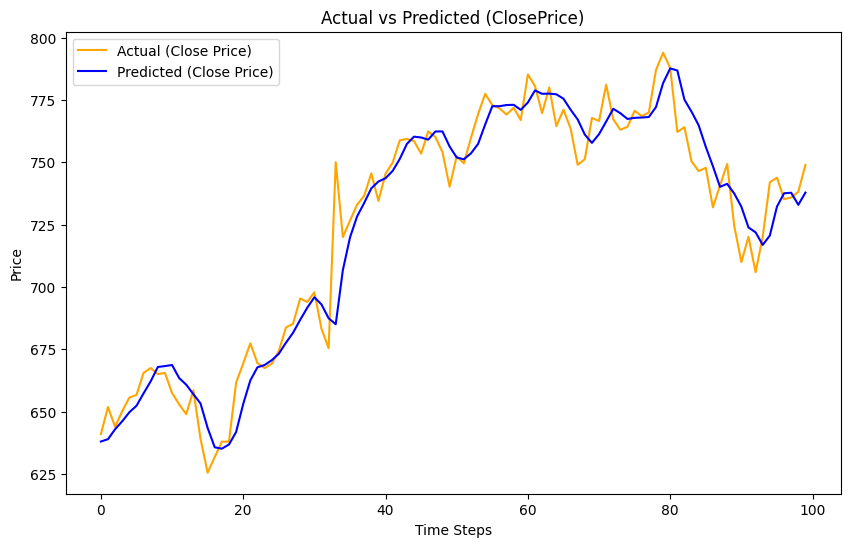

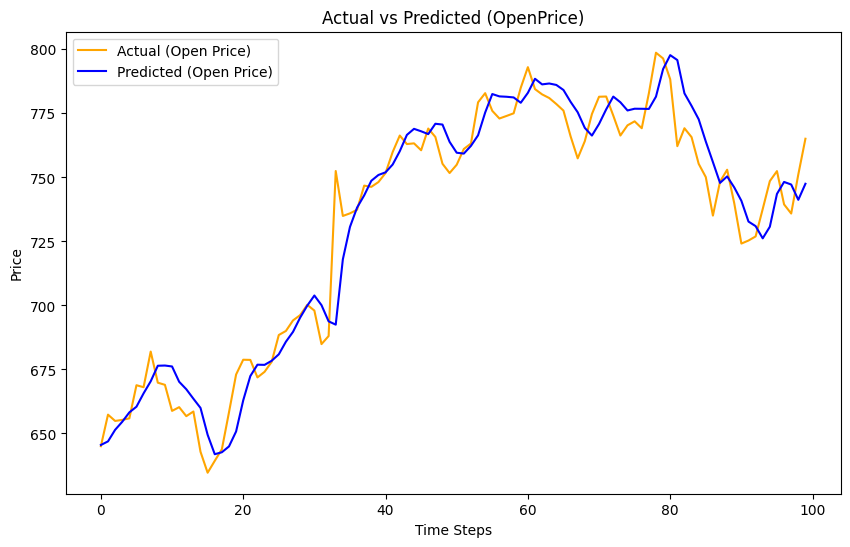

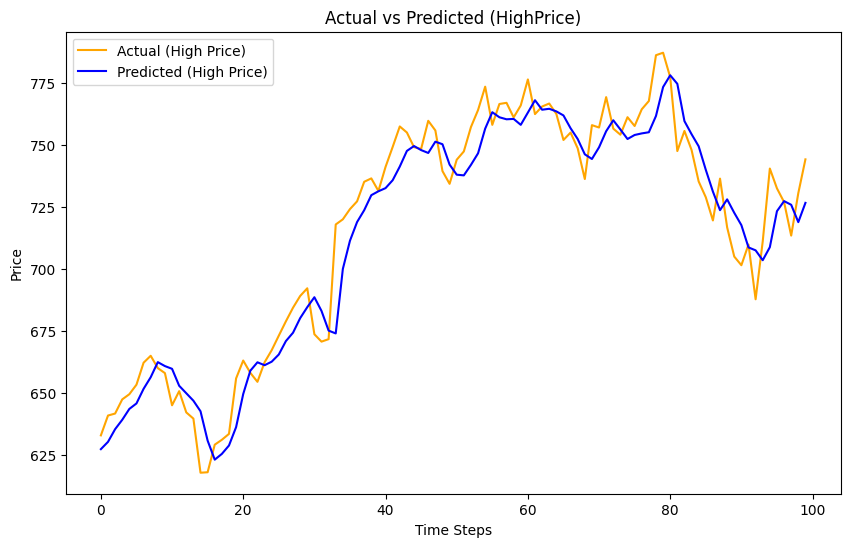

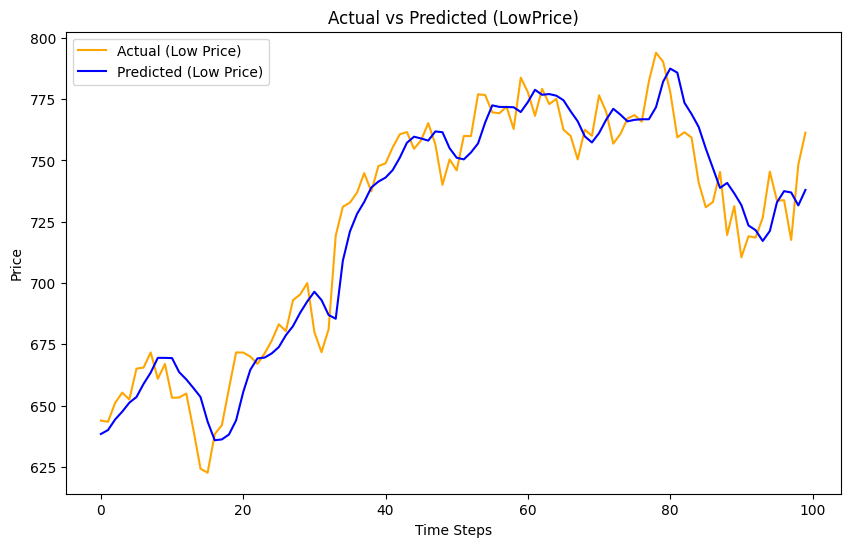

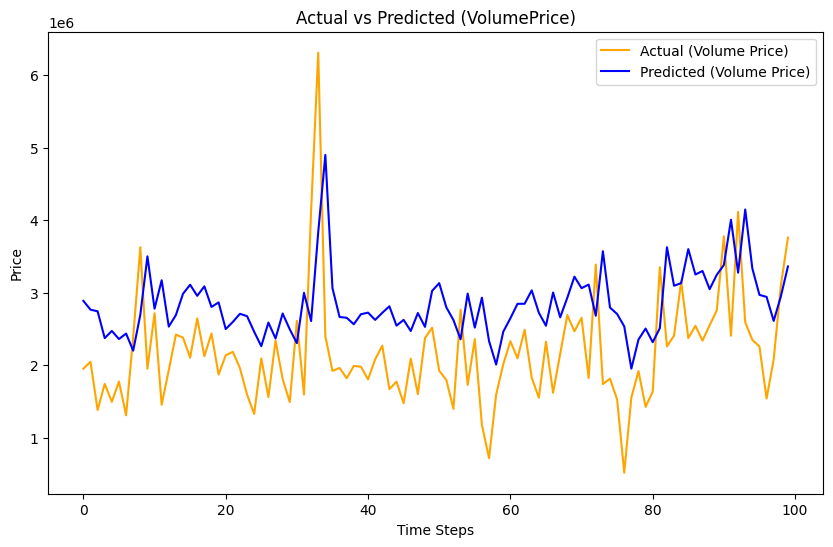

In [13]:
# Plot Actual vs Predicted (Close Price)
variables=["Close", "Open", "High", "Low", "Volume"]
for i in range(0,5):
    variable=variables[i]
    plt.figure(figsize=(10, 6))
    plt.plot(Y_test_rescaled[:100, i], label='Actual ('+variable+' Price)', color='orange')
    plt.plot(predictions_rescaled[:100, i], label='Predicted ('+variable+' Price)', color='blue')
    plt.legend()
    plt.title("Actual vs Predicted ("+variable+"Price)")
    plt.xlabel("Time Steps")
    plt.ylabel("Price")
    #plt.savefig("Actual_vs_Predicted("+variable+"Price)_training.png")
    mse = root_mean_squared_error(Y_test_rescaled[:100,i], predictions_rescaled[:100,i])
    print(f"Root Mean Squared Error: {mse}")
    

Forecast Future Values

In [15]:
# Forecasting future values
forecast_input = X_test[-1]  # Initialize with the last sequence from the test set
forecast_steps = 100  # Number of future steps to forecast
forecasts = []

for _ in range(forecast_steps):
    forecast_input_reshaped = forecast_input.reshape(1, sequence_length, X.shape[2])
    forecast = model.predict(forecast_input_reshaped)[0]
    forecasts.append(forecast)
    forecast_input = np.vstack([forecast_input[1:], forecast])  # Update the input sequence

# Convert forecasts to the original scale
forecasts_rescaled = scaler.inverse_transform(np.array(forecasts))  # Rescale forecasts to original values
print("Forecasts (original scale):")
print(forecasts_rescaled)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

Root Mean Squared Error: 216.40731267703947
Root Mean Squared Error: 223.23541038503515
Root Mean Squared Error: 197.09484125064827
Root Mean Squared Error: 211.20408772223553
Root Mean Squared Error: 3964526.807872168


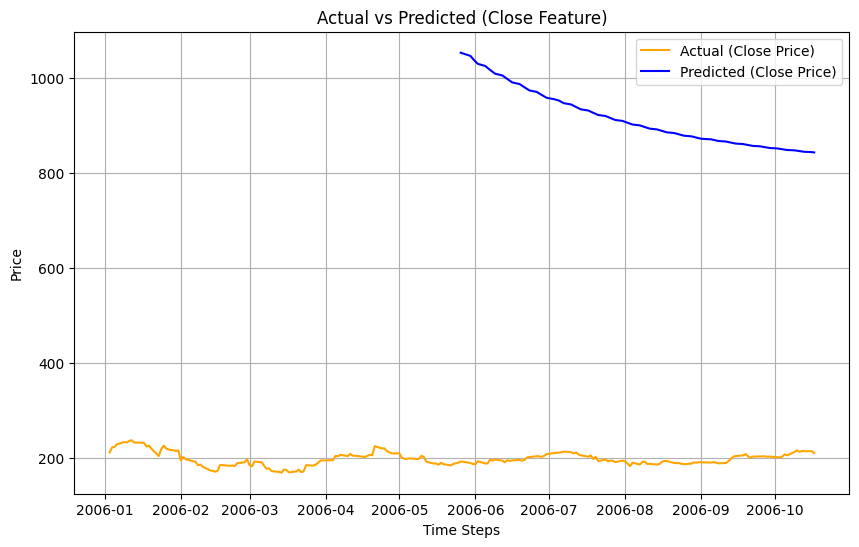

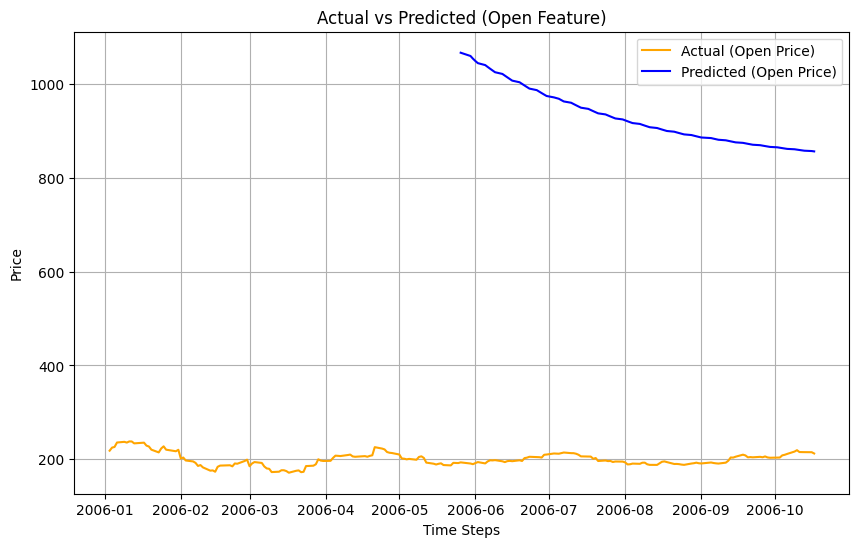

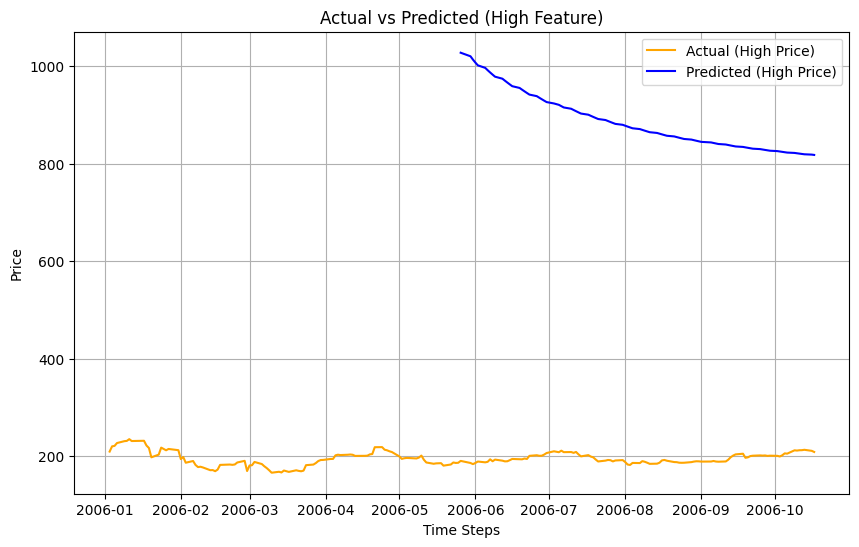

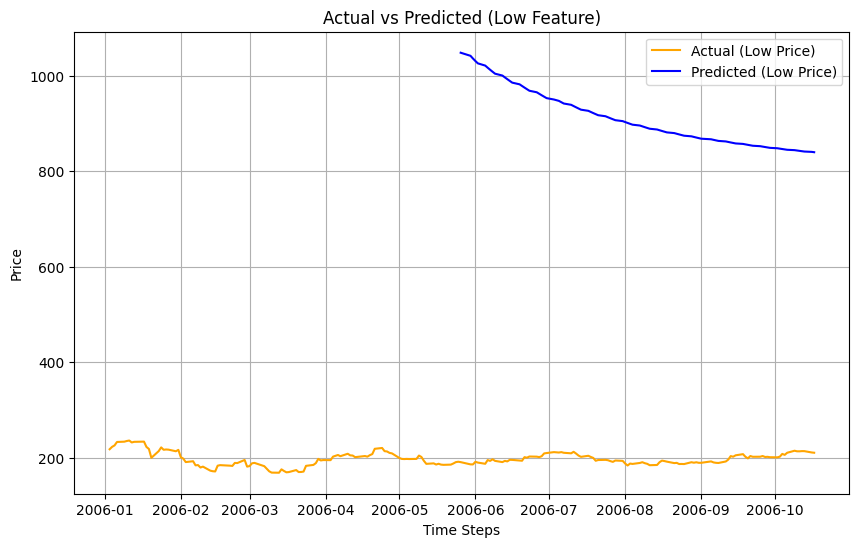

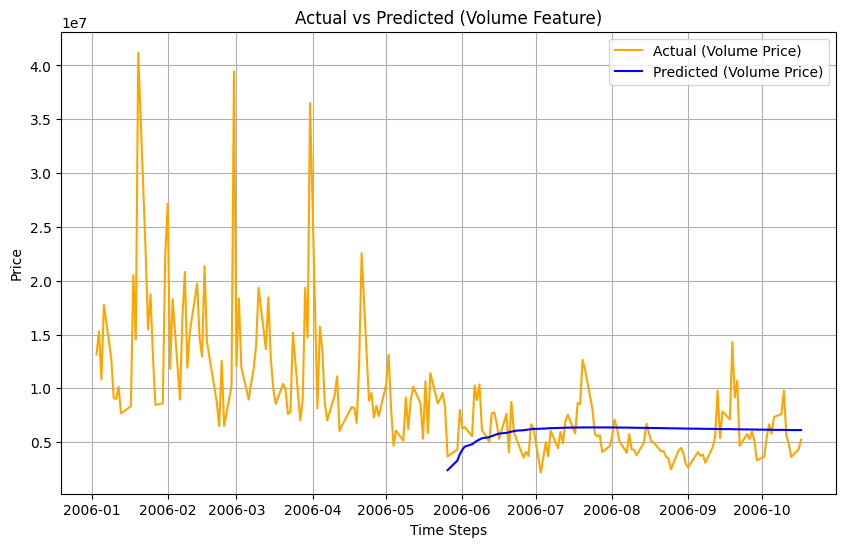

In [16]:
# Plot Actual vs Predicted (First Feature)
for i in range(0,5):
    variable=variables[i]
    plt.figure(figsize=(10, 6))
    plt.plot(df1.index[:200], df1.values[:200, i], label='Actual ('+variable+' Price)', color='orange')  # Actual first feature
    plt.plot(df1.index[100:200], forecasts_rescaled[:, i], label='Predicted ('+variable+' Price)', color='blue')  # Predicted first feature
    plt.legend()
    plt.title("Actual vs Predicted ("+variable+" Feature)")
    plt.xlabel("Time Steps")
    plt.ylabel("Price")
    plt.grid(True)
    #plt.savefig("Actual_vs_Predicted("+variable+")_testing.png")
    mse = root_mean_squared_error(Y_test_rescaled[:100,i], forecasts_rescaled[:100,i])
    print(f"Root Mean Squared Error: {mse}")


In [17]:
mse = mean_squared_error(Y_test_rescaled[484:], forecasts_rescaled)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 6560951163974.439
